In [2]:
from yuning_util.dev_mode import DevMode
dev_mode = DevMode('k-seq')
dev_mode.on()

from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Point estimation

In [3]:
from k_seq.data.seq_table import SeqTable

RES_CSV_PATH = '/mnt/storage/projects/k-seq/working/byo_doped/least_square/point-est_bounded_pod_10-21-19/fit_summary.csv'
byo_doped = SeqTable.load_default_dataset(dataset='byo_doped')
res_table = pd.read_csv(RES_CSV_PATH, index_col=0)

Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo_doped.pkl
Imported!


In [4]:
res_table['input_counts'] = byo_doped.table_filtered.loc[res_table.index, 'R0'].sparse.to_dense() + 0.1
res_table['all_detected'] = res_table.index.isin(byo_doped.table_in_all_samples.index.values)
res_table['kA'] = res_table.k * res_table.A
res_table = res_table.loc[~res_table.isna().any(axis=1)]

,k,A,input_counts,kA,all_detected
CTACTTCAAACAATCGGTCTG,209.576805,0.419282,1452169,87.871727,True
CCACACTTCAAGCAATCGGTC,155.360038,0.455281,1246771,70.732523,True
ATTACCCTGGTCATCGAGTGA,679.435538,0.287239,1114059,195.160061,True
AAGTTTGCTAATAGTCGCAAG,164.256725,0.176522,1421716,28.994925,True
GTACTTCAAACAATCGGTCTG,169.874871,0.306387,85809,52.047506,True
...,...,...,...,...,...
CCTCACTTCAAGCCATTGATC,0.020391,0.032159,3,0.000656,False
AAGTTTGCTAATGGCTGCAAA,0.020391,0.032159,3,0.000656,False
CCACACCTCAACCAATCTGCC,0.010577,0.049764,2,0.000526,False
CGACCTCAAACAACCGGTCAG,0.020391,0.032159,3,0.000656,False


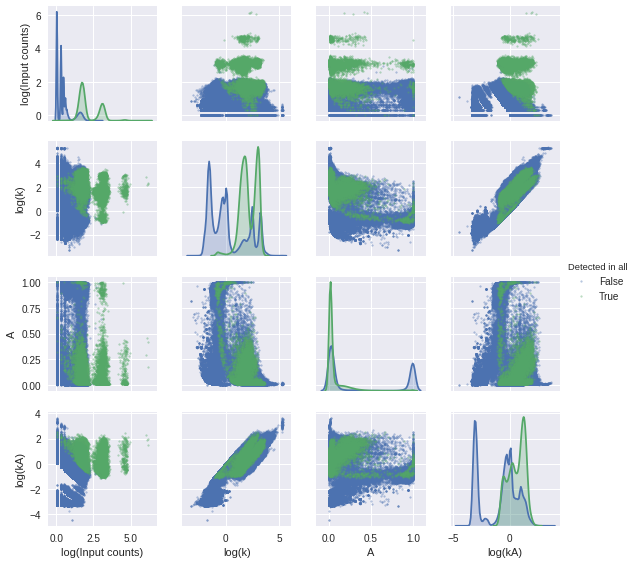

In [78]:
save_fig_to = '/mnt/storage/projects/k-seq/output/2019-11-21_RU_figs/doped_pool_point_est_dist.jpeg'
cols = ['input_counts', 'k', 'A', 'kA', 'all_detected']
names = ['Input counts', 'k', 'A', 'kA', 'Detected in all']
logs = [True, True, False, True, False]
df = res_table
import seaborn as sns

data_to_plot = {}
for name, col, log in zip(names, cols, logs):
    if log:
        data_to_plot[f'log({name})'] = np.log10(df[col])
    else:
        data_to_plot[name] = df[col]
data_to_plot = pd.DataFrame(data_to_plot)

sns.pairplot(data=data_to_plot, vars=data_to_plot.columns.values[:-1], diag_kind='kde', height=2, markers='.',
             hue='Detected in all',
             plot_kws={'edgecolor':None, 'alpha': 0.3, 's':10})

if save_fig_to:
    fig = plt.gcf()
    fig.patch.set_alpha(0)
    fig.savefig(save_fig_to, bbox_inches='tight', dpi=300)

## Relations of k, A, kA, or relative abundance in the initial pool

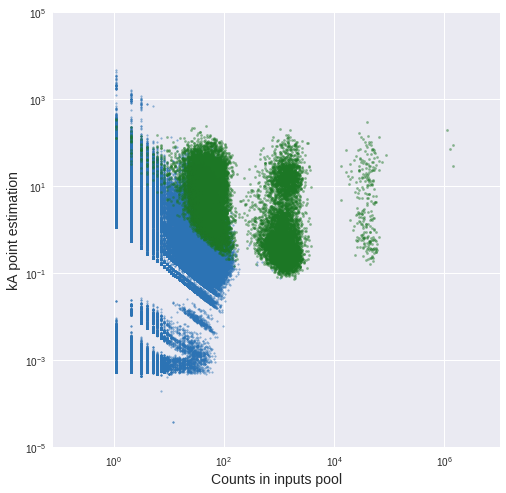

In [8]:
save_fig_to = '/mnt/storage/projects/k-seq/output/2019-11-21_RU_figs/ka_counts_ls_pnt_est.jpeg'

import matplotlib.pyplot as plt
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 1, figsize=[8, 8])

ax.scatter(res_table.loc[res_table['all_detected'], 'input_counts'],
           res_table.loc[res_table['all_detected'],  'kA'], s=5, color='#1C7725', alpha=0.5, zorder=2)
ax.scatter(res_table.loc[~res_table['all_detected'], 'input_counts'],
           res_table.loc[~res_table['all_detected'], 'kA'], s=3, color='#2C73B4', alpha=0.5, zorder=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.08, 1e7])
ax.set_ylim([1e-5, 1e5])
ax.set_xlabel('Counts in inputs pool', fontsize=14)
ax.set_ylabel('kA point estimation', fontsize=14)

if save_fig_to:
    fig.patch.set_alpha(0)
    fig.savefig(save_fig_to, bbox_inches='tight', dpi=300)

plt.show()

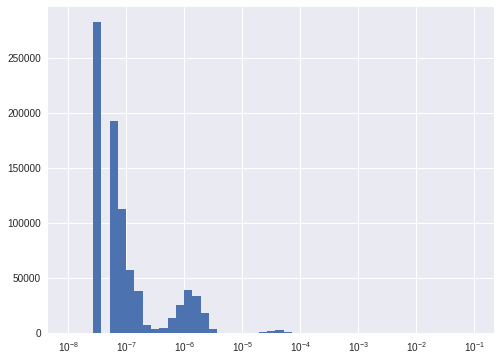

In [173]:
def dist_rel_abun(bin_num=20, bin_range=None, figsize=None):
    import matplotlib.pyplot as plt
    
    if bin_range is None:
        bin_range = [-8, -1]
    if figsize is None:
        figsize = [8, 6]
    
    fig, ax = plt.subplots(1, 1, figsize=[8, 6])
    bins = np.logspace(-8, -1, bin_num, base=10)
    ax.hist(res_table.rel_abun, bins=bins)
    ax.set_xscale('log')
    plt.show()
    
dist_rel_abun(bin_num=50)

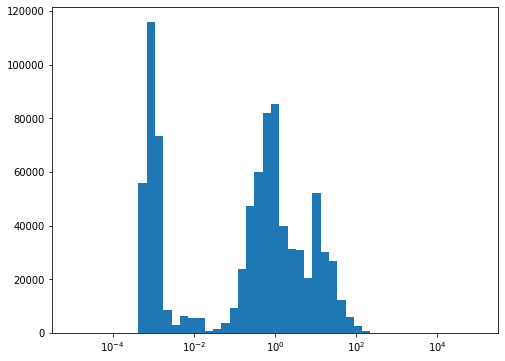

In [169]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
bins = np.logspace(-5, 5, 50)
ax.hist(res_table.kA, bins=bins)
ax.set_xscale('log')
plt.show()

## Bootstrap results

In [5]:
res_table = pd.read_csv('/mnt/storage/projects/k-seq/working/byo_doped/least_square/bs-pct-res-bounded_pod_10-27-19/fit_summary.csv', index_col='Unnamed: 0')

In [6]:
from k_seq.utility import file_tools
results = file_tools.read_pickle('/mnt/storage/projects/k-seq/working/byo_doped/least_square/bs-pct-res-bounded_pod_10-27-19/results.pkl')

KeyboardInterrupt: 

In [7]:
res_table

,k,A,kA,k_mean,k_std,k_2.5%,k_50%,k_97.5%,A_mean,A_std,A_2.5%,A_50%,A_97.5%,kA_mean,kA_std,kA_2.5%,kA_50%,kA_97.5%
CTACTTCAAACAATCGGTCTG,209.576575,0.419282,87.871647,209.294277,48.807784,115.636204,212.410306,302.446449,0.391087,0.039036,0.329493,0.384933,0.478138,80.469043,14.576352,52.296764,80.888363,108.309281
CCACACTTCAAGCAATCGGTC,155.360034,0.455281,70.732521,162.170144,39.189374,90.986799,159.941031,234.612345,0.421794,0.044881,0.350183,0.414900,0.524415,67.210611,12.902003,45.133172,66.214455,92.875414
ATTACCCTGGTCATCGAGTGA,679.435268,0.287239,195.159993,694.479866,154.800273,430.410768,678.543817,1013.196155,0.297186,0.023513,0.254048,0.297472,0.341078,204.080538,37.312180,137.120358,200.543031,276.413476
AAGTTTGCTAATAGTCGCAAG,164.256716,0.176522,28.994923,169.983334,53.309205,80.688170,166.715687,272.334881,0.163142,0.022727,0.124239,0.161287,0.212663,26.851982,6.325247,15.622940,26.878984,38.655715
GTACTTCAAACAATCGGTCTG,169.874846,0.306387,52.047499,173.539354,42.101450,96.245926,171.566355,253.607752,0.282380,0.031388,0.232245,0.278356,0.353009,48.129345,9.355280,30.894812,47.584682,67.003873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTTACTCTGGTCAACGAGTGA,261.382524,0.020099,5.253484,295.107320,223.506022,33.175472,258.230175,853.815692,0.039732,0.035249,0.018599,0.036846,0.064810,9.393239,4.845768,1.676115,9.273359,19.911150
ATTACCCCTGTCCTCGAGTGA,1027.030440,0.016900,17.356338,1090.359330,622.921896,94.175374,1016.406758,2555.854158,0.015744,0.003430,0.009918,0.015468,0.023353,15.818872,7.499247,2.132939,15.464944,31.319339
ATTAGCCCTGTCATCGAGTGA,1454.624406,0.013493,19.627393,1544.615718,936.678395,108.221810,1426.983010,3791.962627,0.014070,0.003324,0.009164,0.013671,0.021974,19.769438,9.779496,2.490464,19.513743,41.852519
AGTACCCGGGACATCGAGTGA,440.291968,0.023271,10.245859,481.497226,328.769447,50.947285,403.241793,1252.858754,0.035134,0.012141,0.019608,0.033826,0.059401,14.670891,7.928753,2.311684,14.019457,32.532270


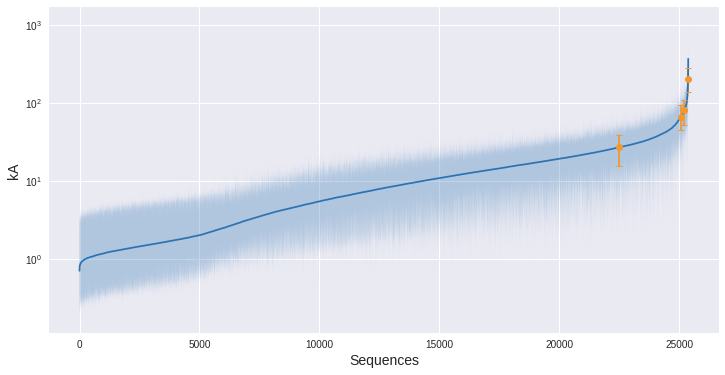

In [14]:
from k_seq.estimator import visualizer
reload(visualizer)


visualizer.param_value_plot(res_table, param='kA', line_postfix='_50%', show_shade=True, sort_by='kA_50%',
                            highlight_seq=['CTACTTCAAACAATCGGTCTG', 'CCACACTTCAAGCAATCGGTC',
                                           'ATTACCCTGGTCATCGAGTGA', 'AAGTTTGCTAATAGTCGCAAG'],
                            y_log=True, save_fig_to='/mnt/storage/projects/k-seq/output/2019-11-21_RU_figs/ci_est_ka.jpeg')

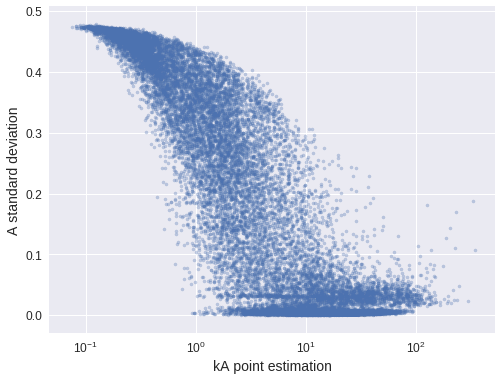

In [8]:
save_fig_to = '/mnt/storage/projects/k-seq/output/2019-11-21_RU_figs/a_std_vs_ka_point_est.jpeg'

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(res_table['kA'], res_table['A_std'], s=10, alpha=0.3)
ax.set_xlabel('kA point estimation', fontsize=14)
ax.set_ylabel('A standard deviation', fontsize=14)
ax.set_xscale('log')
ax.tick_params(labelsize=12)

if save_fig_to:
    fig.patch.set_alpha(0)
    fig.savefig(save_fig_to, bbox_inches='tight', dpi=300)

plt.show()

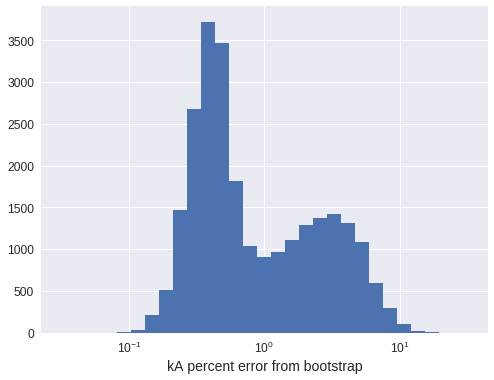

In [16]:
save_fig_to = '/mnt/storage/projects/k-seq/output/2019-11-21_RU_figs/ka_pct_err_point_est_hist.jpeg'

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bins = np.logspace(-1.5, 1.5, 30)
ax.hist(res_table['kA_std'] / res_table['kA'], bins=bins)
ax.set_xlabel('kA percent error from bootstrap', fontsize=14)
# ax.set_ylabel('A standard deviation', fontsize=14)
ax.set_xscale('log')
ax.tick_params(labelsize=12)

if save_fig_to:
    fig.patch.set_alpha(0)
    fig.savefig(save_fig_to, bbox_inches='tight', dpi=300)

plt.show()

# Compare to previous estimation
Here we used old results of k-seq on selected pool with Abe's script for comparison
> `/mnt/storage/projects/k-seq/datasets/byo_on_abes_method/allseqs-name-fit_repeat.csv`

As well as reported value in the paper

In [17]:
REF_PATH = '/mnt/storage/projects/k-seq/datasets/byo_on_abes_method/allseqs-name-fit_repeat.csv'
ref_table = pd.read_csv(REF_PATH, index_col='X')[2:]
ref_table

,Abun R5c-counts.txt,L by avg,k by avg,L stdev,k stdev
X,,,,,
GGGGGGAGAAGTTAATGG,0.000191,0.999411,50.765753,0.000000,0.000000
GGGGGAAATGTCAGGTCATGC,0.000191,0.337199,0.674452,0.007564,0.015246
GGGGGAAATTCCAAGGTCATG,0.000191,0.975867,14.310327,0.314230,39.507303
GGGGGAATCCTACGTGTCAAG,0.000191,0.710566,3.027453,0.294333,4.993080
GGGGGAACCGGGTGGCCCCGA,0.000191,0.337198,0.674450,0.007562,0.015242
...,...,...,...,...,...
CCCCC,0.000382,0.337199,0.674452,0.007564,0.015246
CCCC,0.000382,0.999564,55.043066,0.001454,22.233369
CCC,0.002290,0.993262,23.779244,0.009470,17.871010


In [20]:
ref_table.loc['CTACTTCAAACAATCGGTCTG']

Abun R5c-counts.txt      15.233418
L by avg                  0.282805
k by avg               5219.032763
L stdev                   0.068896
k stdev                1749.466495
Name: CTACTTCAAACAATCGGTCTG, dtype: float64

In [ ]:
selected_seqs = {
    'S-2.1-a': ('ATTACCCTGGTCATCGAGTGA', 779, 0.161),
    'S-2.1-t': ('ATTACCCTGGTCATCGAGTGT', 729, 0.158),
    'S-1A.1-a': ('CTACTTCAAACAATCGGTCTG', 121, 0.283),
    'S-1B.1-a': ('CCACACTTCAAGCAATCGGTC', 46.2, 0.865),
   # 'S-1B.2-a': ('CCGCTTCAAGCAATCGGTCGC', 47.3, 0.669),
    'S-1B.3-a': ('CCGAGTTTCAAGCAATCGGTC', 71.2, 0.458),
    'S-3.1-a': ('AAGTTTGCTAATAGTCGCAAG', 142, 0.134),
   # 'S-2.2-a': ('ATTCACCTAGGTCATCGGGTG', 197, 0.132),
   # 'S-1A.1-n': ('CTCTTCAAACAATCGGTCTTC', 74.9, 0.251),
    'S-1C.1-a': ('CTCTTCAATAATCGGTTGCGT', 6.65, 1.000)
}
